# Imports and Settings

In [9]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb

shap.initjs()

In [11]:
# Allow imports from parent directory
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

In [13]:
def correlation_heatmap(df: pd.DataFrame, out: bool = False) -> None:
    """
    Displays correlations between numerical features of a DataFrame.
    `out` set to True allows to export the graph in png format in the graphs folder.
    """
    corr = df.select_dtypes(include="number").corr()
    # Create a matrix full of zeros similar to corr
    mask = np.zeros_like(corr)
    # Set the upper triangle of the mask to True
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
      fig, ax = plt.subplots(figsize=(6, 6))
      ax = sns.heatmap(
        corr,
        # MASK
        mask=mask,
        # Div palette, suffix _r to reverse
        cmap="RdBu_r", # coolwarm, vlag, icefire
        # Text in heatmap
        annot=True,# Allowing annotations.
        fmt=".2f", # Formatting annotations. 
        annot_kws=dict(
          fontsize=9,
          fontweight="bold"
          ), # Other formatting
        # Values on vertical colorbar
        vmax=1,
        center=0,
        vmin=-1,
        )
    plt.title("Correlations Heatmap", size="xx-large", weight="bold", c="b")

    if out:
        plt.savefig("graphs/correlations_heatmap.png", dpi=300)
        
    plt.show()

# Data Loading

Nous allons utiliser le dataset des Abalone.

[**Lien vers la documentation**](https://archive.ics.uci.edu/dataset/1/abalone)

In [2]:
columns = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
    ]

data = pd.read_csv("data/abalone.data", names = columns)

# Overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Basic EDA

## Scatterplot of `rings` vs `whole_weight`

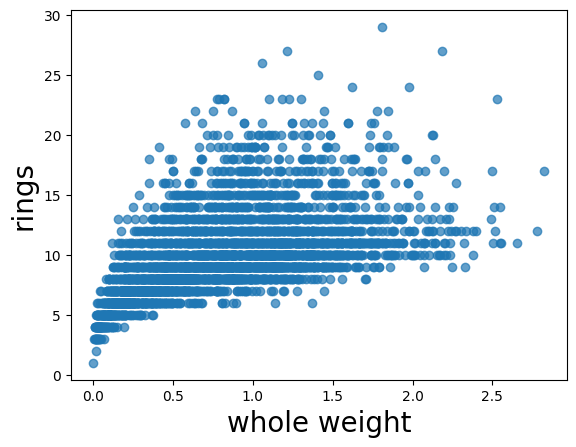

In [6]:
plt.scatter(data["whole weight"], data["rings"], alpha=0.7)
plt.ylabel("rings", size=20)
plt.xlabel("whole weight", size=20)
plt.show()

## Boxplot of `rings` vs `sex`

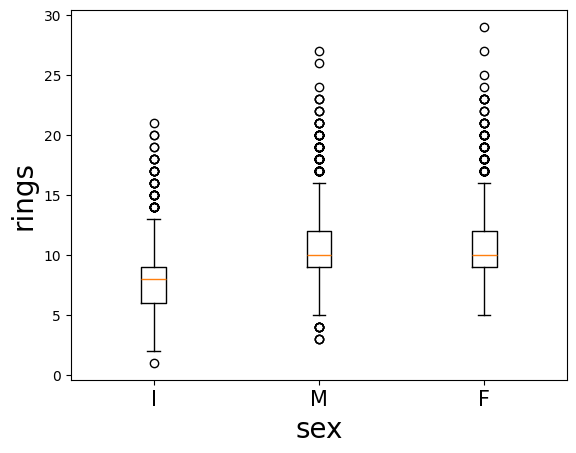

In [8]:
plt.boxplot(data[data.sex == "I"]["rings"], positions=[1])
plt.boxplot(data[data.sex == "M"]["rings"], positions=[2])
plt.boxplot(data[data.sex == "F"]["rings"], positions=[3])

plt.xticks(ticks=[1, 2, 3], labels=["I", "M", "F"], size=15)
plt.ylabel("rings", size=20)
plt.xlabel("sex", size=20)
plt.show()

## Correlation Heatmap

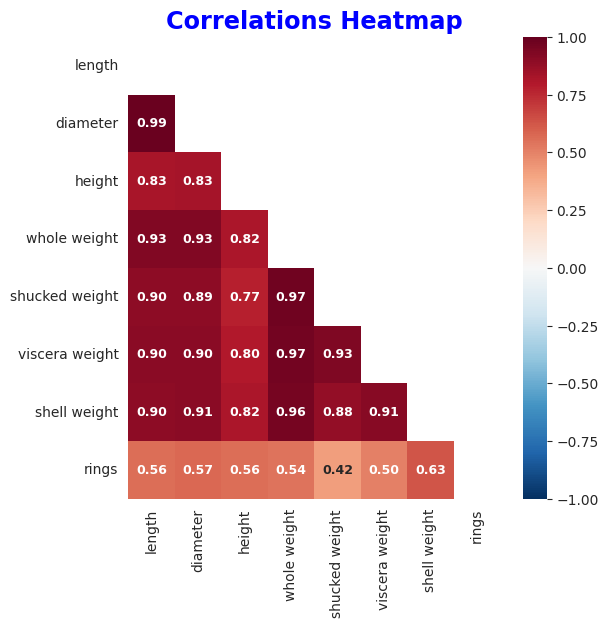

In [14]:
cols = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]

df = data[cols]

correlation_heatmap(df)

# Feature Engineering

Vu les corrélations, on va droper pas mal de variables.

In [15]:
y = data["rings"]
X = data[["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]]

In [16]:
# create dummy variables
X["sex.M"] = [1 if s == "M" else 0 for s in X["sex"]]
X["sex.F"] = [1 if s == "F" else 0 for s in X["sex"]]
X["sex.I"] = [1 if s == "I" else 0 for s in X["sex"]]
X = X.drop("sex", axis=1)

X.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


# Modelling

**NB**: Pour la démonstration, nous procèderons sans hold-out.

## Training

In [17]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Scatterplot Predicted VS Actual

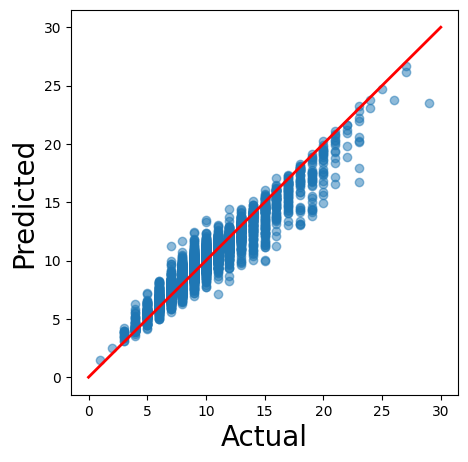

In [21]:
# get predictions
y_pred = model.predict(X)

# model evaluation
plt.figure(figsize=(5, 5))

plt.scatter(y, y_pred, alpha=0.5)
plt.plot([0, 30], [0, 30], color="r", linestyle="-", linewidth=2)

plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.show()

# SHAP

## Standard SHAP Values

In [30]:
# Obtenir les shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [31]:
# Shape check
shap_values.values.shape

(4177, 8)

### Waterfall Plot

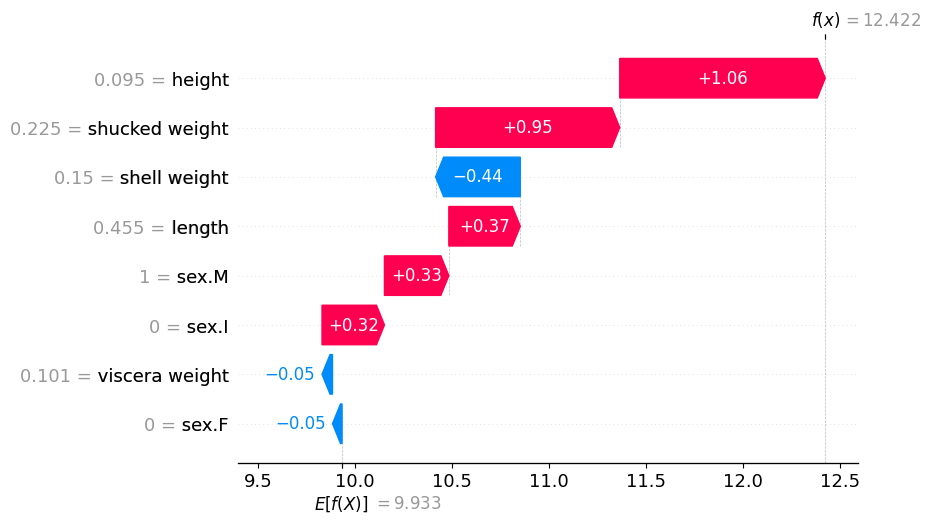

In [32]:
# Waterfall plot pour la première observation
shap.plots.waterfall(shap_values[0])

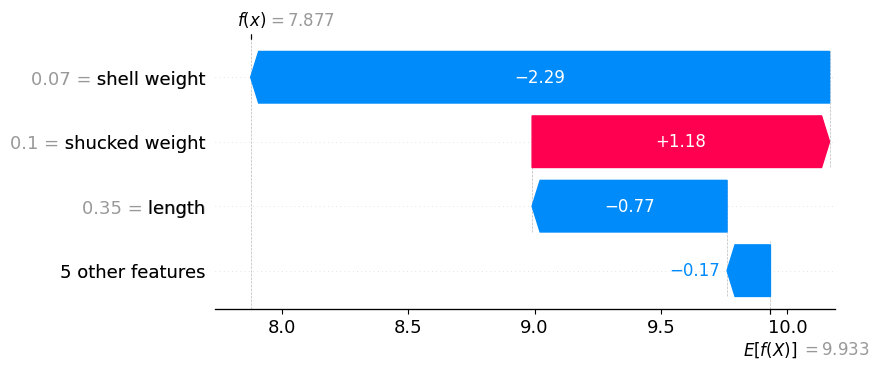

In [47]:
# On peut limiter, de manière décroissante, le nombre de features présentées
# Remarquez que la dernière barre résume l'impact de TOUTES les features les moins influentes
shap.plots.waterfall(shap_values[1], max_display=4)

## SHAP Aggrégations

### Force Plot

In [33]:
# force plot
shap.plots.force(shap_values[0])

### Stacked Force Plot

In [34]:
# stacked force plot
shap.plots.force(shap_values[0:100])

### Absolute Mean SHAP

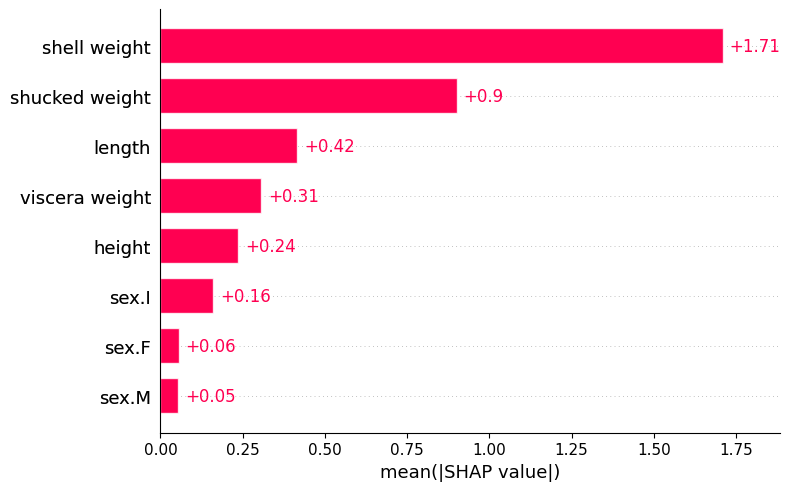

In [36]:
# mean SHAP
shap.plots.bar(shap_values)

### Beeswarm Plot

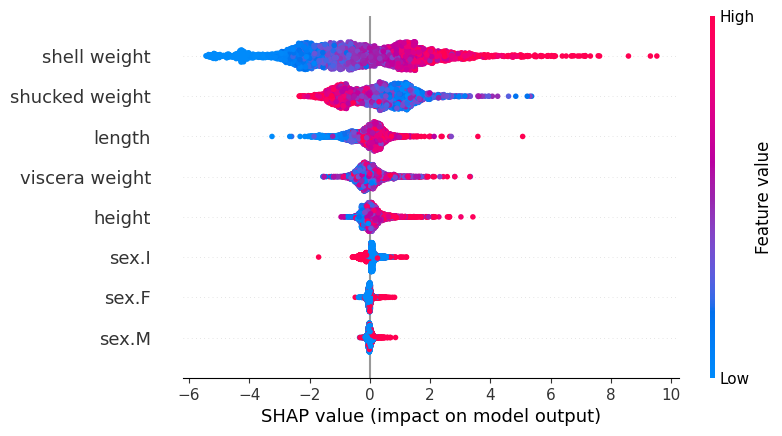

In [37]:
# beeswarm plot
shap.plots.beeswarm(shap_values)

### Violin Plots

#### Classique

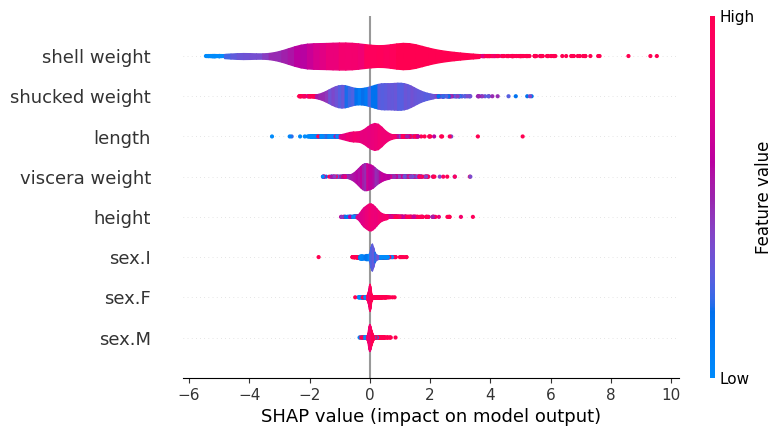

In [38]:
# violin plot
shap.plots.violin(shap_values)

#### Layered

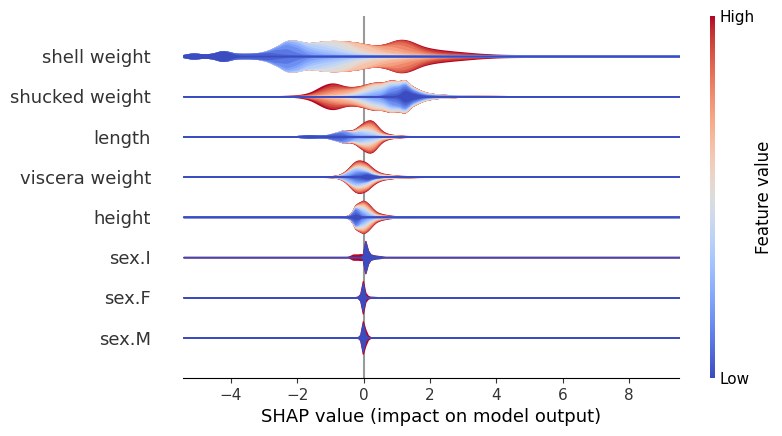

In [39]:
# layered violin plot
shap.plots.violin(shap_values, plot_type="layered_violin")

### Heatmaps

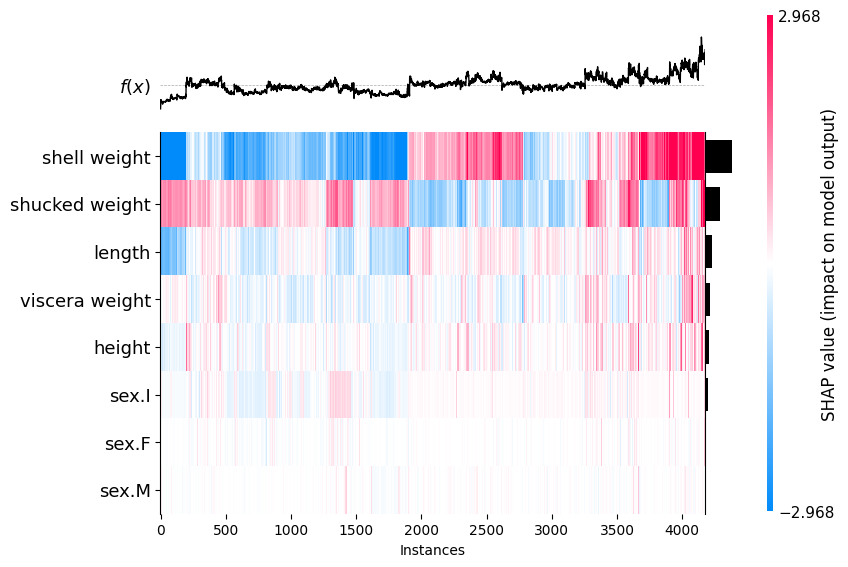

CPU times: user 1min 28s, sys: 717 ms, total: 1min 28s
Wall time: 1min 28s


In [41]:
%%time
# heatmap
shap.plots.heatmap(shap_values)

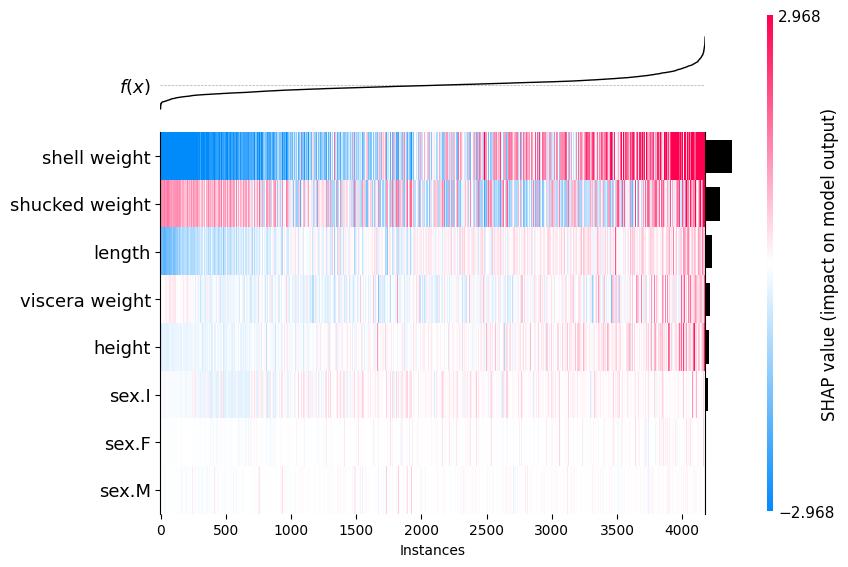

In [42]:
# order by predictions
order = np.argsort(y_pred)
shap.plots.heatmap(shap_values, instance_order=order)

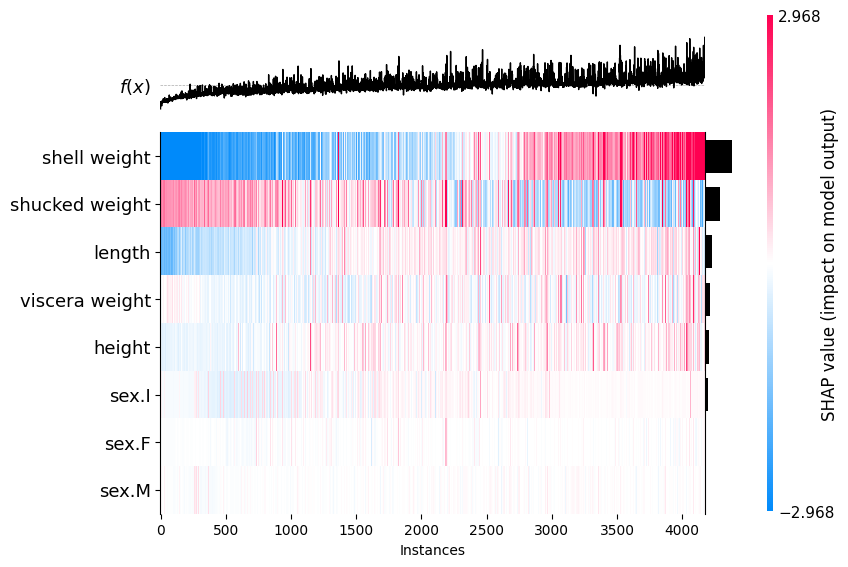

In [43]:
# order by shell weight value
order = np.argsort(data["shell weight"])
shap.plots.heatmap(shap_values, instance_order=order)

### Dependence Plots

#### SHAP Value vs `shell weight`

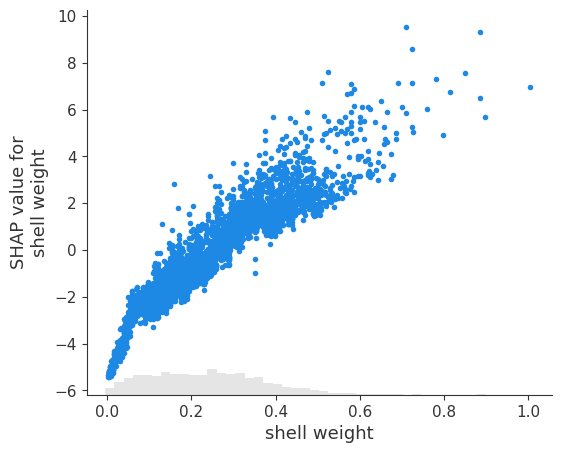

In [44]:
# plot 1: shell weight
shap.plots.scatter(shap_values[:, "shell weight"])

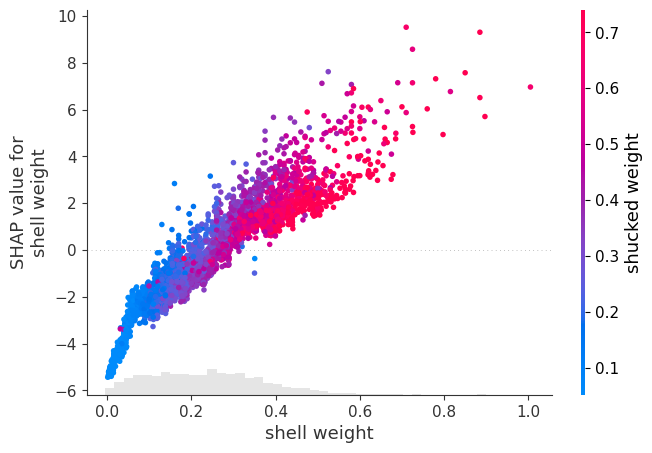

In [45]:
shap.plots.scatter(
    shap_values[:, "shell weight"], color=shap_values[:, "shucked weight"]
)

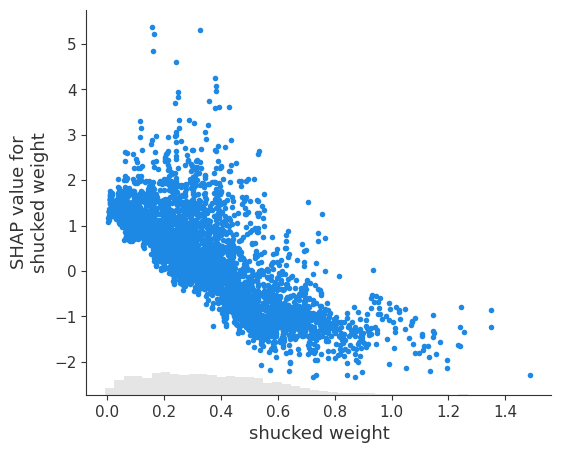

In [46]:
# plot 2: shucked weight
shap.plots.scatter(shap_values[:, "shucked weight"])